In [1]:
import numpy as np
import pandas as pd
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
import scorecardpy as sc
import pickle
from sklearn.pipeline import Pipeline
from data_preparation.additional_transformers import GiniSelector
from data_preparation.transform_features import remove_nans, full_pipeline_logisitic
from sklearn.preprocessing import FunctionTransformer

/home/ZXCVQ/.conda/envs/ING-den/lib/python3.12/site-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [2]:
train_data = pd.read_csv('https://files.challengerocket.com/files/lions-den-ing-2024/development_sample.csv')
test_data = pd.read_csv('https://files.challengerocket.com/files/lions-den-ing-2024/testing_sample.csv')

In [3]:
x_train, y_train = remove_nans(train_data)
x_test, y_test = remove_nans(test_data)

In [4]:
y_train=y_train.astype(bool)
y_test=y_test.astype(bool)

In [5]:
x_train.columns

Index(['customer_id', 'application_date', 'Application_status',
       'Number of applicants', 'Loan purpose', 'Distribution channel',
       'Application amount', 'Credit duration (months)', 'Payment frequency',
       'Installment amount', 'Value of the goods (car)',
       'Application data: income of main applicant',
       'Application data: income of second applicant',
       'Application data: profession of main applicant',
       'Application data: profession of second applicant',
       'Application data: employment date (main applicant)',
       'Application data: marital status of main applicant',
       'Application data: number of children of main applicant',
       'Application data: number of dependences of main applicant',
       'Spendings estimation', 'Property ownership for property renovation',
       'Clasification of the vehicle (Car, Motorbike)',
       'Number of requests during the last 3 months (External data)',
       'Number of requests during the last 6 mon

In [6]:
full_pipeline_logisitic.fit_transform(x_train, y_train).columns

/home/ZXCVQ/Main/Eco/Ekonometria/Lions-Den_Challenge/ING-den/data_preparation/transform_features.py:88: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_copy['Application_status'] = X_copy['Application_status'].replace("Approved", 1)
/home/ZXCVQ/.conda/envs/ING-den/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1149: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  cols = cols[cols.str.contains(self.pattern, regex=True)]


Index(['scale__zero_fill__Application data: income of second applicant',
       'scale__zero_fill__Value of the goods (car)',
       'scale__fill_zeros_but_add_var__Amount on current account',
       'scale__fill_zeros_but_add_var__Amount on savings account',
       'scale__remainder__customer_id',
       'scale__remainder__Number of applicants',
       'scale__remainder__Application amount',
       'scale__remainder__Credit duration (months)',
       'scale__remainder__Payment frequency',
       'scale__remainder__Installment amount',
       'scale__remainder__Application data: income of main applicant',
       'scale__remainder__Application data: number of children of main applicant',
       'scale__remainder__Application data: number of dependences of main applicant',
       'scale__remainder__Spendings estimation',
       'scale__remainder__Number of requests during the last 3 months (External data)',
       'scale__remainder__Number of requests during the last 6 months (External d

In [7]:
model = LogisticRegression(penalty=None)

pipe = Pipeline([
    ('preprocessing' ,full_pipeline_logisitic),
    ('droping not used', FunctionTransformer(lambda x: x.drop(['scale__remainder__customer_id', 'remainder__remainder__application_date', 'remainder__application_status_transform__Application_status', 'remainder__remainder__Application data: employment date (main applicant)'], axis=1))),
    ('Delete features with gini lower than 0.01', GiniSelector(0.01)), 
    ('Smart Correlated Selection', SmartCorrelatedSelection( variables=None,
                                                             method="pearson",
                                                             threshold=0.8,
                                                             missing_values="raise",
                                                             selection_method="variance",
                                                             estimator=None,).set_output(transform="pandas")),
    ('Sequential Feature Selector', SequentialFeatureSelector(model, 
                                                              n_features_to_select='auto', 
                                                              tol=0.005, 
                                                              scoring='roc_auc', 
                                                              cv=5).set_output(transform="pandas")),
    ('Logistic regression', model)
])
pipe.fit(x_train, y_train)

/home/ZXCVQ/Main/Eco/Ekonometria/Lions-Den_Challenge/ING-den/data_preparation/transform_features.py:88: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_copy['Application_status'] = X_copy['Application_status'].replace("Approved", 1)
/home/ZXCVQ/.conda/envs/ING-den/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1149: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  cols = cols[cols.str.contains(self.pattern, regex=True)]


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('columntransformer-1',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('zero_fill',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'),
                                                                   ['Application '
                                                                    'data: '
                                                                    'income of '
                                                                    'second '
                                                                    'applicant',
                                                                    'Application '
                                                                    'data: '
                                                                    'profession '
                                                                    'of second '
                                                                    'applicant',
                                                                    'Value of '
                                                                    'the goods '
                                                                    '(car)']),
                                                                  ('add_third_category',
                                                                   Simpl...
                ('Delete features with gini lower than 0.01',
                 GiniSelector(threshold=0.01)),
                ('Smart Correlated Selection',
                 SmartCorrelatedSelection(missing_values='raise',
                                          selection_method='variance')),
                ('Sequential Feature Selector',
                 SequentialFeatureSelector(estimator=LogisticRegression(penalty=None),
                                           scoring='roc_auc', tol=0.005)),
                ('Logistic regression', LogisticRegression(penalty=None))])

In [8]:
# features removed by gini
pipe.steps[2][1].get_feature_names_out()

['scale__zero_fill__Application data: income of second applicant',
 'scale__zero_fill__Value of the goods (car)',
 'scale__fill_zeros_but_add_var__Amount on current account',
 'scale__fill_zeros_but_add_var__Amount on savings account',
 'scale__remainder__Number of applicants',
 'scale__remainder__Application amount',
 'scale__remainder__Credit duration (months)',
 'scale__remainder__Payment frequency',
 'scale__remainder__Installment amount',
 'scale__remainder__Application data: income of main applicant',
 'scale__remainder__Application data: number of children of main applicant',
 'scale__remainder__Application data: number of dependences of main applicant',
 'scale__remainder__Limit on credit card',
 'scale__remainder__Average income (Exterval data)',
 'scale__remainder___r_',
 'remainder__fill_zeros_but_add_var__Amount on current account_was_missing',
 'remainder__fill_zeros_but_add_var__Amount on savings account_was_missing']

In [9]:
# features selected in SmartCorrelatedSelection
pipe.steps[3][1].get_feature_names_out()

['scale__remainder__Spendings estimation',
 'scale__remainder__Number of requests during the last 3 months (External data)',
 'scale__remainder__Number of requests during the last 9 months (External data)',
 'scale__remainder__Number of requests during the last 12 months (External data)',
 'scale__remainder__Credit bureau score (Exterval data)',
 'woe_encode__zero_fill__Application data: profession of second applicant',
 'woe_encode__mode_impute__Loan purpose',
 'woe_encode__mode_impute__Distribution channel',
 'woe_encode__remainder__Application data: profession of main applicant',
 'woe_encode__remainder__Application data: marital status of main applicant',
 'remainder__add_third_category__Property ownership for property renovation',
 'remainder__add_third_category__Clasification of the vehicle (Car, Motorbike)',
 'remainder__remainder__Arrear in last 3 months (indicator)',
 'remainder__remainder__Arrear in last 12 months (indicator)']

In [10]:
# features selected in Sequential Feature Selector
pipe.steps[4][1].get_feature_names_out()

array(['scale__remainder__Spendings estimation',
       'scale__remainder__Credit bureau score (Exterval data)',
       'woe_encode__zero_fill__Application data: profession of second applicant',
       'woe_encode__mode_impute__Loan purpose',
       'woe_encode__remainder__Application data: profession of main applicant',
       'woe_encode__remainder__Application data: marital status of main applicant',
       'remainder__remainder__Arrear in last 12 months (indicator)'],
      dtype=object)

In [11]:
x_train_transformed=Pipeline(pipe.steps[:-1]).transform(x_train)
x_test_transformed=Pipeline(pipe.steps[:-1]).transform(x_test)

/home/ZXCVQ/Main/Eco/Ekonometria/Lions-Den_Challenge/ING-den/data_preparation/transform_features.py:88: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_copy['Application_status'] = X_copy['Application_status'].replace("Approved", 1)
/home/ZXCVQ/Main/Eco/Ekonometria/Lions-Den_Challenge/ING-den/data_preparation/transform_features.py:88: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_copy['Application_status'] = X_copy['Application_status'].replace("Approved", 1)


In [12]:
#model.fit(x_train, y_train)

train_proba=pipe.predict_proba(x_train)[:,1]
test_proba=pipe.predict_proba(x_test)[:,1]

/home/ZXCVQ/Main/Eco/Ekonometria/Lions-Den_Challenge/ING-den/data_preparation/transform_features.py:88: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_copy['Application_status'] = X_copy['Application_status'].replace("Approved", 1)
/home/ZXCVQ/Main/Eco/Ekonometria/Lions-Den_Challenge/ING-den/data_preparation/transform_features.py:88: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_copy['Application_status'] = X_copy['Application_status'].replace("Approved", 1)


In [13]:
roc_auc_score(y_train, train_proba), roc_auc_score(y_test, test_proba)

(0.7562616007368528, 0.736296601866653)

/home/ZXCVQ/.conda/envs/ING-den/lib/python3.12/site-packages/scorecardpy/condition_fun.py:131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dat.loc[:,y] = dat[y].apply(lambda x: x if pd.isnull(x) else int(x)) #dat[y].astype(int)


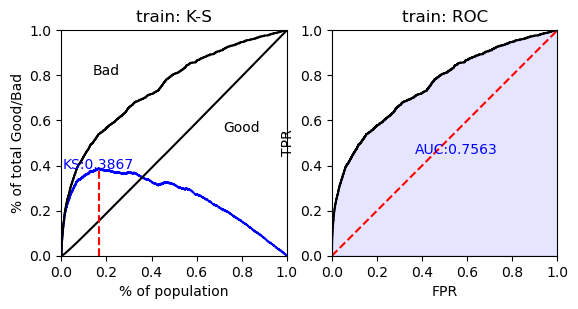

/home/ZXCVQ/.conda/envs/ING-den/lib/python3.12/site-packages/scorecardpy/condition_fun.py:131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dat.loc[:,y] = dat[y].apply(lambda x: x if pd.isnull(x) else int(x)) #dat[y].astype(int)


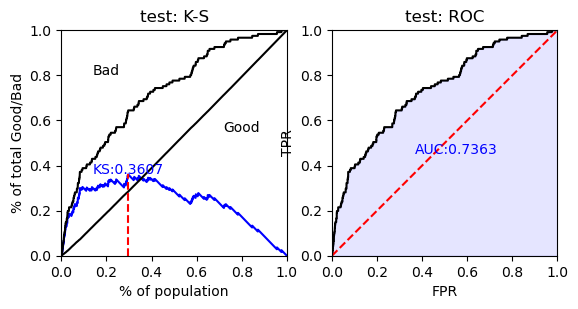

In [14]:
train_perf = sc.perf_eva(y_train, train_proba, title = "train")
test_perf = sc.perf_eva(y_test, test_proba, title = "test")

In [15]:
x_train_transformed.to_pickle("./Intermidiate_data/x_train_logistic.pk")
y_train.to_pickle("./Intermidiate_data/y_train_logistic.pk")
x_train_transformed.to_pickle("./Intermidiate_data/x_test_logistic.pk")
y_test.to_pickle("./Intermidiate_data/y_test_logistic.pk")

with open("./Intermidiate_data/model_logistic.pk", 'wb') as f:
    pickle.dump(pipe.steps[-1][1], f)
